In [17]:
import importlib
import warnings

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import json
import sys
import os

import kad.visualization.visualization as visualization
from kad.kad_utils import kad_utils
from kad.kad_utils.kad_utils import customize_matplotlib
import kad.model.lstm_model as lstm_model
import kad.models_evaluation.models_evaluator as models_evaluator

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

import kad.ts_analyzer.ts_analyzer as ts_analyzer
from kad.model import i_model
from sklearn.model_selection import train_test_split

customize_matplotlib()

['/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/notebooks', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/IPython/extensions', '/home/maciek/.ipython', '/snap/pycharm-professional/248/plugins/python/helpers/pydev', '/snap/pycharm-professional/248/plugins/python/helpers-pro/jupyter_debug']


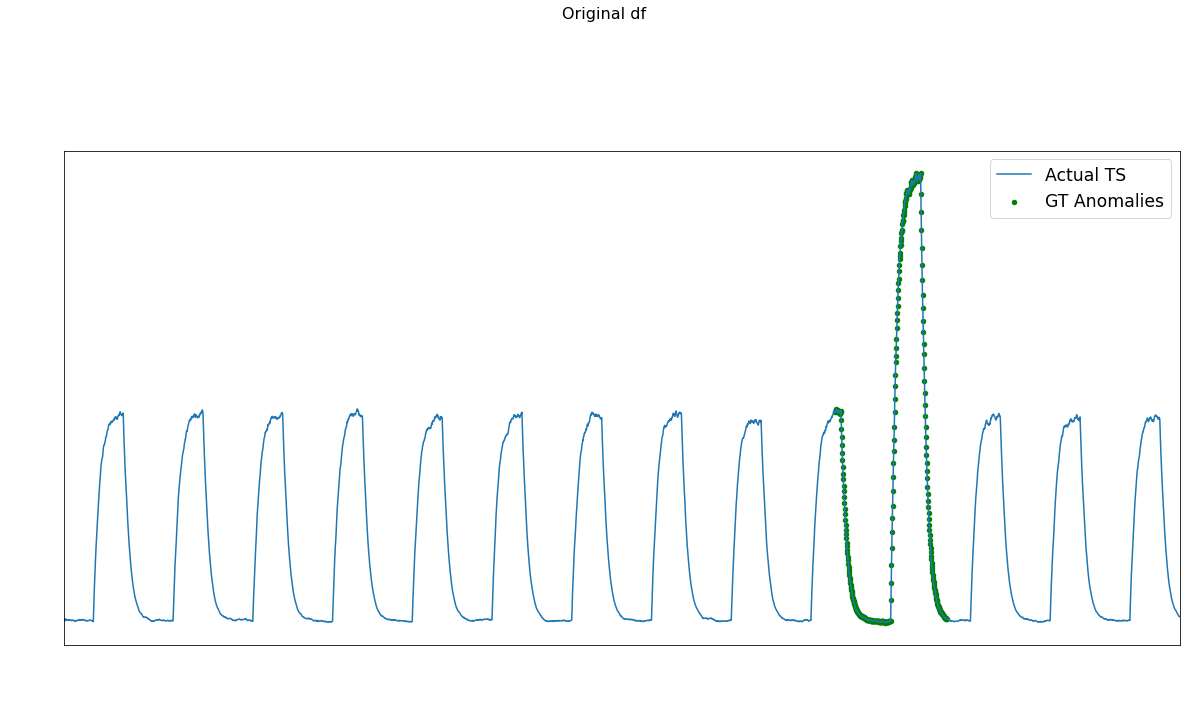

In [18]:
data_dir = "data/archive/"
file_dir = "artificialWithAnomaly"
file_name = "artificialWithAnomaly/art_daily_jumpsup.csv"

file_path = os.path.join(data_dir, file_dir, file_name)

original_df = pd.read_csv(
    file_path, parse_dates=True, index_col="timestamp"
)

# original_df = original_df.resample("h").agg(np.mean)
original_df = original_df.ewm(halflife='1 hour', times=original_df.index).mean()

with open("data/archive/combined_windows.json") as f:
    true_anomalies = json.load(f)

X_LABEL = "timestamp"
ts_analyzer = importlib.reload(ts_analyzer)
visualization = importlib.reload(visualization)

true_anomalies_ranges = true_anomalies[file_name]

ground_true_anomalies_df = pd.DataFrame()
for anom_range in true_anomalies_ranges:
    ground_true_anomalies_df = ground_true_anomalies_df.append(original_df.loc[anom_range[0]:anom_range[1]])

preprocessed_df = original_df.copy()
preprocessed_df["gt_is_anomaly"] = [idx in ground_true_anomalies_df.index for idx in original_df.index.tolist()]

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Original df")


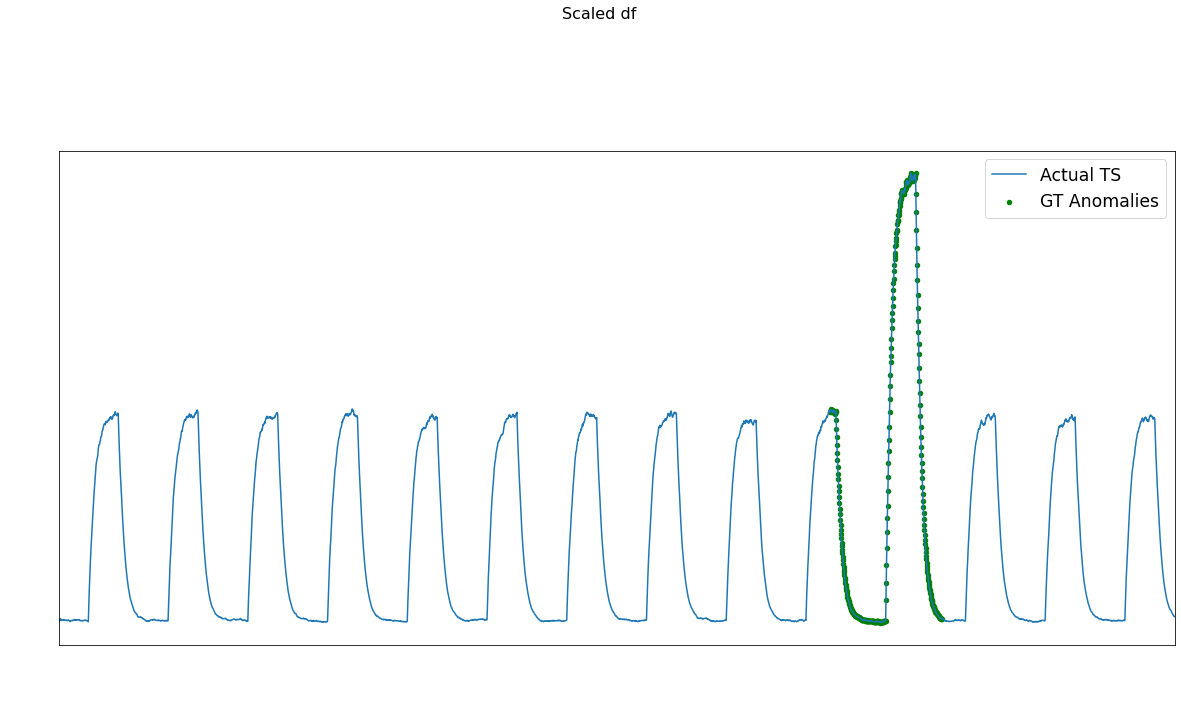

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Scaled df")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 12, 64)            16896     
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
18/18 [==============================] - 2s 28ms/step - loss: 0.0618 - val_loss: 0.0109

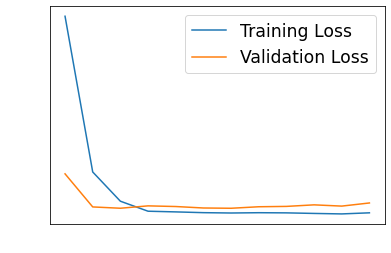

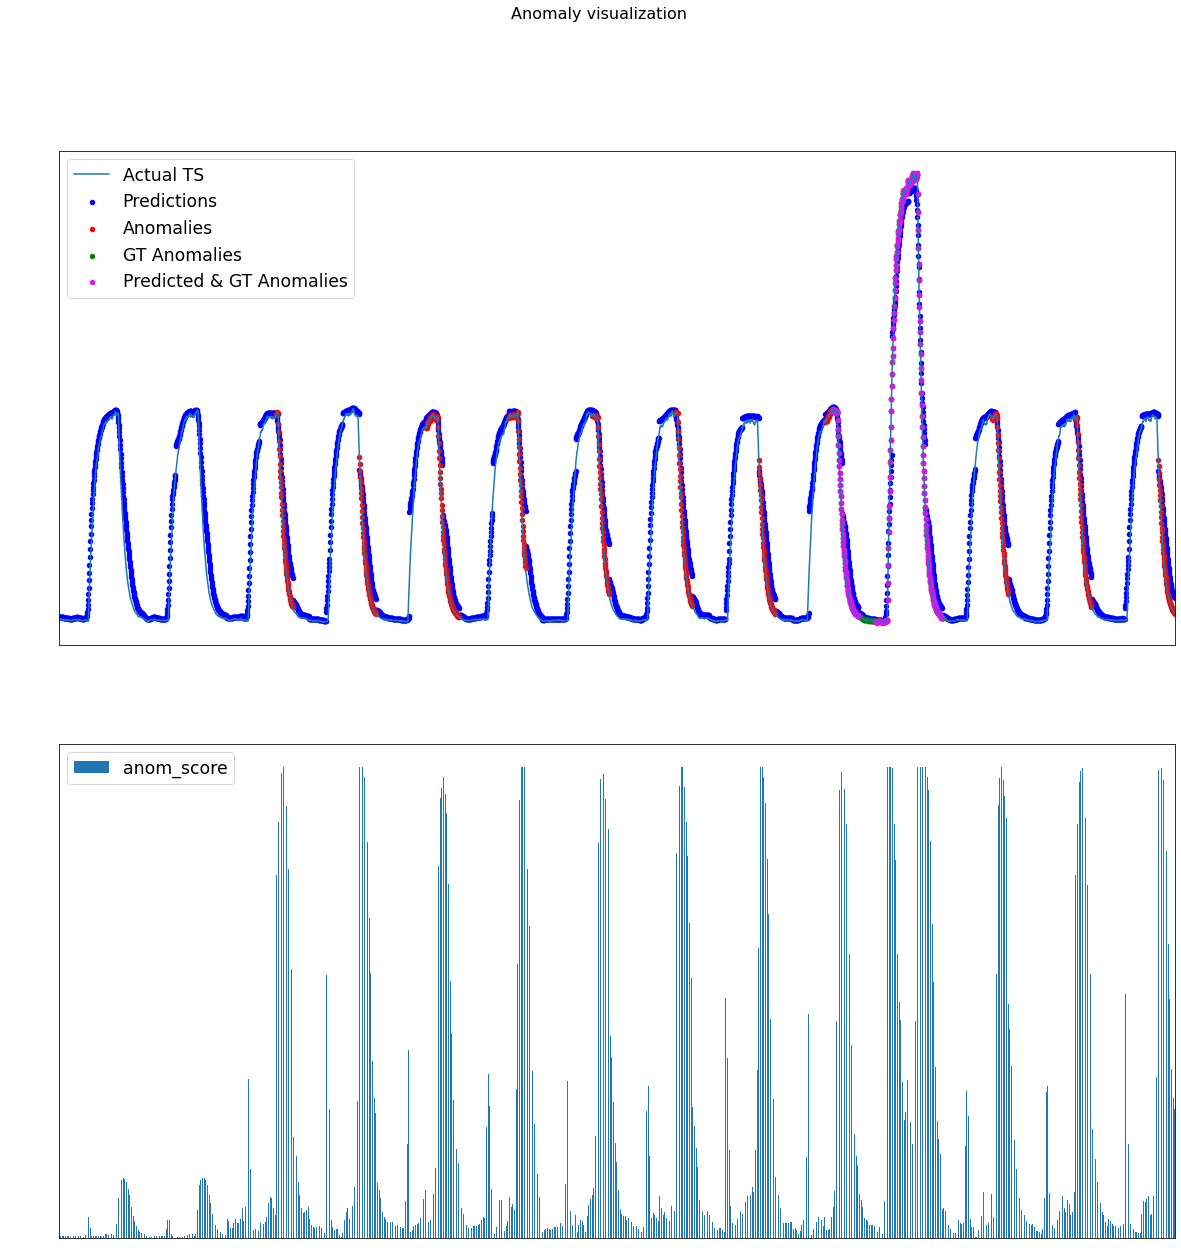

In [20]:
kad_utils = importlib.reload(kad_utils)
lstm_model = importlib.reload(lstm_model)
warnings.filterwarnings("ignore")

model: i_model.IModel = lstm_model.LstmModel(time_steps=12)


values_df = preprocessed_df[["value"]]
train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
model.train(train_df)

results_df = pd.DataFrame()
SAMPLES_TO_PREDICT = 60
for i in range(0, len(test_df), SAMPLES_TO_PREDICT):
    if len(test_df.iloc[i:i + SAMPLES_TO_PREDICT]) < SAMPLES_TO_PREDICT:
        break
    results_df = model.test(test_df.iloc[i:i + SAMPLES_TO_PREDICT])

evaluation_df = results_df.copy()
evaluation_df["gt_is_anomaly"] = preprocessed_df["gt_is_anomaly"]
visualization = importlib.reload(visualization)
visualization.visualize(evaluation_df, "value")

Accuracy:  0.78
Avg precision:  0.25


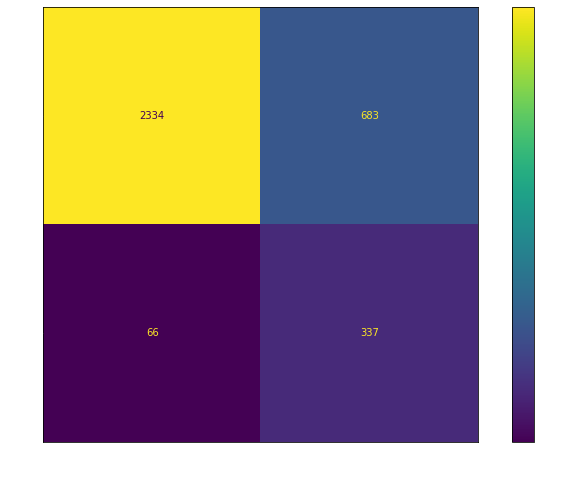

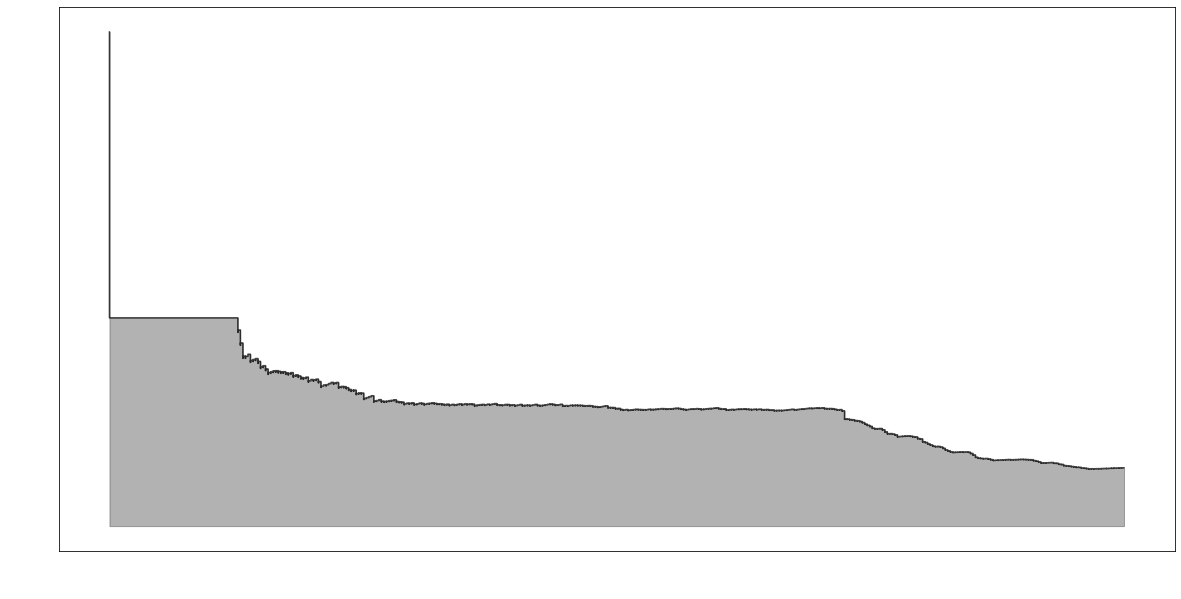

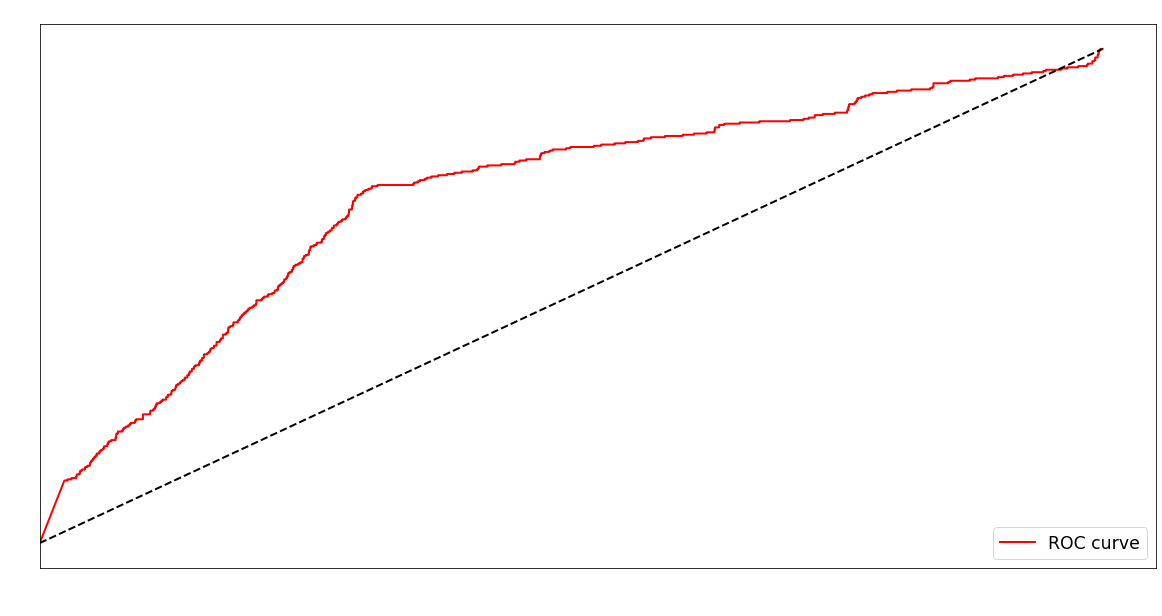

In [21]:
models_evaluator = importlib.reload(models_evaluator)

final_df = evaluation_df.loc[test_df.index & evaluation_df.index]
evaluator = models_evaluator.ModelsEvaluator(df=final_df)

print("Accuracy: ", evaluator.get_accuracy())
print("Avg precision: ", evaluator.get_average_precision())

evaluator.plot_confusion_matrix()

evaluator.plot_precision_recall_curve()
evaluator.plot_roc()
